In [2]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9c3fa887246a88380a8cf5e79ea52dce8efbcaba510524471f5a0d2eba2a37d4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [6]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression

from pyspark.sql.functions import col, sum as sql_sum

from pyspark.sql.types import IntegerType

from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.util import MLUtils

import matplotlib.pyplot as plt

from pyspark.ml.stat import Correlation

import sys as sns

In [5]:
spark = SparkSession.builder \
   .appName("linear_regression") \
   .getOrCreate()

train_data = spark.read.format("csv") \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .load("file:////content/financial_loan.csv")
train_data.show()

### load data from csv file ###


+-------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-----------------+---------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|     id|address_state|application_type|emp_length|           emp_title|grade|home_ownership|issue_date|last_credit_pull_date|last_payment_date|loan_status|next_payment_date|member_id|purpose|sub_grade|      term|verification_status|annual_income|   dti|installment|int_rate|loan_amount|total_acc|total_payment|
+-------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-----------------+---------+-------+---------+----------+-------------------+-------------+------+-----------+--------+-----------+---------+-------------+
|1077430|           GA|      INDIVIDUAL|  < 1 year|             

In [7]:
train_data.describe().show()

+-------+------------------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-----------------+-----------------+------------------+---------+----------+-------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+
|summary|                id|address_state|application_type|emp_length|           emp_title|grade|home_ownership|issue_date|last_credit_pull_date|last_payment_date|loan_status|next_payment_date|        member_id|           purpose|sub_grade|      term|verification_status|     annual_income|                dti|       installment|           int_rate|       loan_amount|         total_acc|    total_payment|
+-------+------------------+-------------+----------------+----------+--------------------+-----+--------------+----------+---------------------+-----------------+-----------+-------------

In [8]:
cleaned_df = train_data.na.drop()

In [14]:
### changing the type of the columns ###
df = cleaned_df.withColumn("address_state", col("address_state").cast("string")) \
               .withColumn("application_type", col("application_type").cast("string"))\
               .withColumn("grade", col("application_type").cast("string")) \
               .withColumn("emp_length", col("emp_length").cast("string")) \
               .withColumn("emp_title", col("emp_title").cast("string")) \
               .withColumn("grade", col("grade").cast("string")) \
               .withColumn("home_ownership", col("home_ownership").cast("string")) \
               .withColumn("issue_date", col("issue_date").cast("string")) \
               .withColumn("annual_income", col("annual_income").cast("string")) \
               .withColumn("last_credit_pull_date", col("last_credit_pull_date").cast("string")) \
               .withColumn("last_payment_date", col("last_payment_date").cast("string")) \
               .withColumn("loan_status", col("loan_status").cast("string")) \
               .withColumn("next_payment_date", col("next_payment_date").cast("string")) \
               .withColumn("purpose", col("purpose").cast("string")) \
               .withColumn("sub_grade", col("sub_grade").cast("string")) \
               .withColumn("term", col("term").cast("string")) \
               .withColumn("verification_status", col("verification_status").cast("string"))

### Now you can proceed with the StringIndexer for multiple columns , stringInexer here : changing the string to dummy varaible (numberic_value) ###
indexer = StringIndexer(inputCols=["address_state", "application_type", "emp_length", "emp_title",
                                   "grade", "home_ownership", "issue_date", "last_credit_pull_date",
                                   "last_payment_date", "loan_status", "next_payment_date", "purpose",
                                   "sub_grade", "term", "verification_status","grade"],
                        outputCols=["address_state_indexed", "application_type_indexed",
                                    "emp_length_indexed", "emp_title_indexed", "grade_indexed",
                                    "home_ownership_indexed", "issue_date_indexed",
                                    "last_credit_pull_date_indexed", "last_payment_date_indexed",
                                    "loan_status_indexed", "next_payment_date_indexed",
                                    "purpose_indexed", "sub_grade_indexed", "term_indexed",
                                    "verification_status_indexed", "grade_index"]).fit(df)

# Transform the DataFrame
indexed_df = indexer.transform(df)
#indexed_df.show()

# corr_coef = indexed_df.stat.corr("annual_income", "loan_amount")
# print("correlation between 2 coloumns are :: ", corr_coef)


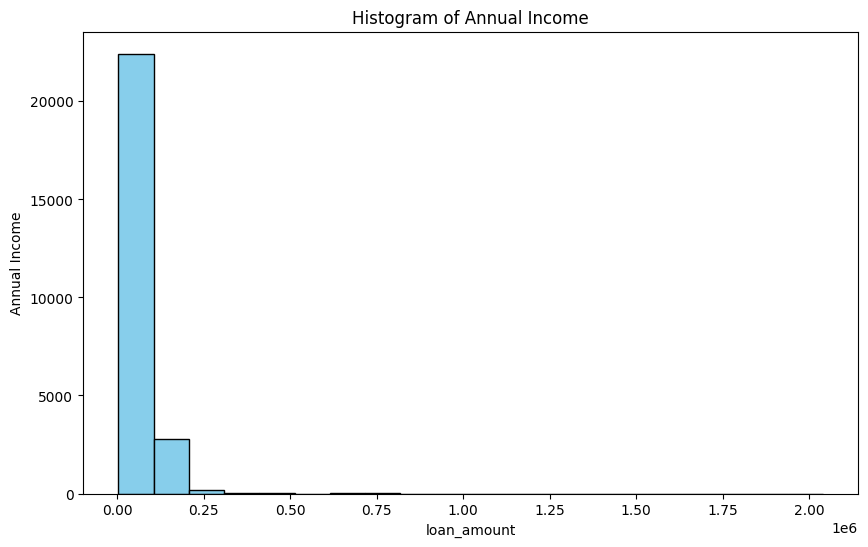

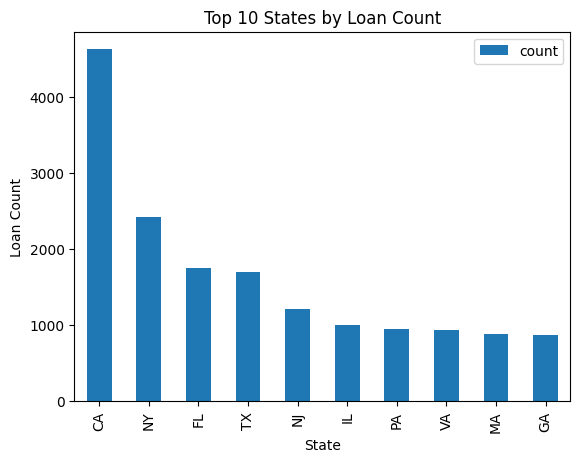

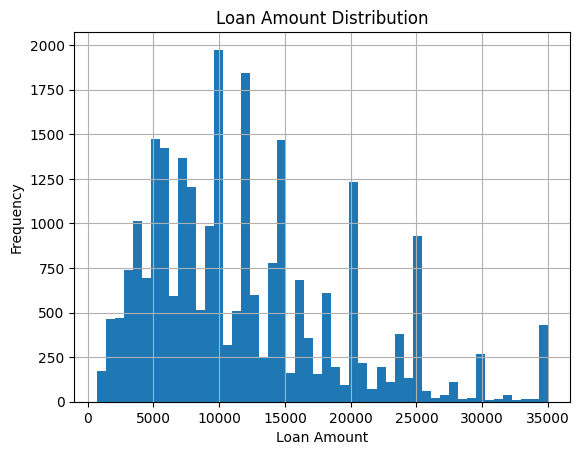

In [15]:
pandas_df = cleaned_df.select("annual_income", "dti", "installment", "int_rate", "loan_amount", "total_acc", "total_payment").toPandas()
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['annual_income'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('loan_amount')
plt.ylabel('Annual Income')
plt.title('Histogram of Annual Income')
plt.show()

state_counts = indexed_df.groupBy("address_state").count().orderBy("count", ascending=False).limit(10)
state_counts.toPandas().plot(kind="bar", x="address_state", y="count")
plt.title("Top 10 States by Loan Count")
plt.xlabel("State")
plt.ylabel("Loan Count")
plt.show()


loan_amounts = indexed_df.select("loan_amount")
loan_amounts.toPandas().hist(bins=50)
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()




In [16]:
### using vectorassembler as the assembler to change the numiric value of the cols in to row vector value  as  'Independent_features' ###

assembler = VectorAssembler(inputCols=['id',
 'grade_index',
 'installment',
 'int_rate',
 'total_acc',
 'total_payment',
 'emp_length_indexed',
 'grade_indexed',
 'home_ownership_indexed',
 'issue_date_indexed',
 'last_credit_pull_date_indexed',
 'last_payment_date_indexed',
 'loan_status_indexed',
 'next_payment_date_indexed',
 'purpose_indexed',
 'loan_amount' ,
 'sub_grade_indexed'],
 outputCol='Independant_Features')

output  = assembler.transform(indexed_df)

final_df = output.select("Independant_Features","loan_amount")

training, test = final_df.randomSplit([0.7, 0.3])

random_forest_reg = RandomForestRegressor(featuresCol="Independant_Features",labelCol="loan_amount",maxBins=200)

model = random_forest_reg.fit(training)

predictions_1 = model.transform(training) # checking the accuracy of the traning dataset

prediction_2 = model.transform(test) # checking the accuracy of the test dataset



In [17]:

evaluator = RegressionEvaluator(labelCol="loan_amount",\
                                predictionCol="prediction", metricName="r2")
print("R Squared (R2) on traning data =", evaluator.evaluate(predictions_1))


evaluator = RegressionEvaluator(labelCol="loan_amount",\
                                predictionCol="prediction", metricName="r2")
print("R Squared (R2) on test data =", evaluator.evaluate(prediction_2))

R Squared (R2) on traning data = 0.9826159171577421
R Squared (R2) on test data = 0.9833042480388636
